In [1]:
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



In [ ]:

exp_name = 'mul_amp/MD_ablation'
results_folder = './../results2/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]

regexes = [f"\d_{float(amp):1.1f}_1.3" for amp in [10, 20, 30, 35, 40, 50, 100]] # 0, 1, 2 ,3,4 ,5, 
labels = [f'mul amp {amp}' for amp in [10, 20, 30, 35, 40, 50, 100]]


ax = plt.gca()
means, stds = [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)] 
    if len(comp_files) > 0:    
        smooth_performances = [np.convolve(np.load(c1f), np.ones((40,))/40, mode='valid') for c1f in comp_files]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
# plt.savefig(f'./exports/mul_amp2.{file_format}', format=file_format, dpi=300)




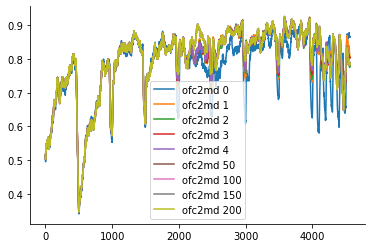

In [2]:
# %%

exp_name = 'time_steps/OFC_ablation'
results_folder = './../results2/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
exps = {0: 'ofc off', 1: 'ofc2md', 2:'ofc2dlPFC', 3:'mul_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

ax = plt.gca()
means, stds = [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
# plt.savefig(f'./exports/ofc.{file_format}', format=fil
# 
# e_format, dpi=300)

# %%


Text(0, 0.5, 'perfomance avg in 30 trials')

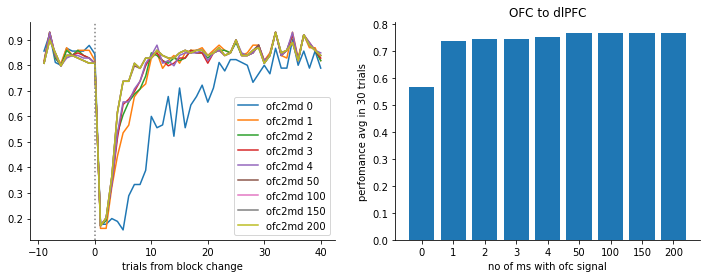

In [3]:
#Isolate and stack change point performance
def get_cp_perf(config, performances, window = 30):
    vt = np.cumsum(config.variable_trials_per_block)[np.array(config.ofc_control_schedule[:len(config.variable_trials_per_block)])=='on']
    vt = vt[:-1] # exclude last entry, just the end trial

    change_perf = [performance[cp-10:cp+window+10] for cp in vt for performance in performances]
    cp = np.vstack(change_perf)
    return(cp)

fig, axes = plt.subplots(1,2, figsize=[12, 4])
window = 30
means =[]
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        config = np.load(conf_files[0], allow_pickle=True).item()

    cp = get_cp_perf(config, performances, window=window)
    means.append((cp.mean(0)[10:10+window]).mean())
    ax = axes[0]
    ax.plot(range(-9, window+11), cp.mean(0) , label=label)
ax.axvline(0, linestyle=':', color='grey')
ax.legend()
ax.set_xlabel('trials from block change')
ax = axes[1]
ax.bar([lab[7:] for lab in labels], means)
ax.set_title('OFC to dlPFC')
ax.set_xlabel('no of ms with ofc signal')
ax.set_ylabel('perfomance avg in 30 trials')
#baserline
# plt.savefig('./exports/MD.jpg', dpi=300)
